In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

<h3>Setting up SQL Alchemy for reading data</h6>

In [2]:
from sqlalchemy import create_engine
from sqlalchemy import (
    Column,
    ForeignKey,
    Integer,
    DateTime,
    Float,
    DateTime,
    Float,
    String,
    Text,
)
from sqlalchemy.orm import relationship
from sqlalchemy.orm import sessionmaker
import sqlalchemy as db
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import text

USERNAME = "root"
PASSWORD = "1831"
SERVER = "localhost"

# DEFINE THE ENGINE (CONNECTION OBJECT)
engine = create_engine(
    f"mysql+pymysql://{USERNAME}:{PASSWORD}@{SERVER}:3306/currencies", echo=False
)

Base = declarative_base()

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16244\2949199030.py:28: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [3]:
class Currency(Base):
    __tablename__ = "currency"

    id = Column(Integer, primary_key=True, unique=True, autoincrement=True)
    name = Column(String(255), nullable=True)
    symbol = Column(String(255), nullable=True)
    rank = Column(Integer, nullable=True)
    main_link = Column(Text, nullable=True)
    historical_link = Column(Text, nullable=True)
    circulating_supply = Column(Float, nullable=True)

    # github = relationship("Github", back_populates="currency")  # , uselist=False
    historicals = relationship("Historical", back_populates="currency")
    languages = relationship(
        "Language", secondary="languages_currency", back_populates="currencies"
    )
    tags = relationship("Tag", secondary="tags_currency", back_populates="currencies")

    def __repr__(self):
        return f"<Currency(id={self.id}, name='{self.name}', symbol='{self.symbol}')>"

In [4]:
class GitHub(Base):
    __tablename__ = "github"

    id = Column(Integer, primary_key=True, unique=True, autoincrement=True)
    currency_id = Column(Integer, ForeignKey("currency.id"), nullable=True)
    commits_count = Column(Integer, nullable=True)
    contributors_count = Column(Integer, nullable=True)
    forks_count = Column(Integer, nullable=True)
    stars_count = Column(Integer, nullable=True)
    github_link = Column(Text, nullable=True)

    # Define a foreign key relationship to the 'currency' table
    currency = relationship("Currency")

    def __repr__(self):
        return f"<GitHub(id={self.id}, currency_id={self.currency_id})>"

In [5]:
class Historical(Base):
    __tablename__ = "historical"

    id = Column(Integer, primary_key=True, unique=True, autoincrement=True)
    currency_id = Column(Integer, ForeignKey("currency.id"), nullable=True)
    timeOpen = Column(DateTime, nullable=True)
    timeClose = Column(DateTime, nullable=True)
    timeHigh = Column(DateTime, nullable=True)
    timeLow = Column(DateTime, nullable=True)
    open = Column(Float, nullable=True)
    high = Column(Float, nullable=True)
    low = Column(Float, nullable=True)
    close = Column(Float, nullable=True)
    volume = Column(Float, nullable=True)
    marketCap = Column(Float, nullable=True)
    timestamp = Column(DateTime, nullable=True)

    # Define a foreign key relationship to the 'currency' table
    currency = relationship("Currency", back_populates="historicals")

    def __repr__(self):
        return f"<Historical(id={self.id}, currency_id={self.currency_id}, timestamp={self.timestamp})>"

In [6]:
class Language(Base):
    __tablename__ = "languages"

    id = Column(Integer, primary_key=True, unique=True, nullable=False)
    name = Column(String(255), nullable=True)

    # Define a one-to-many relationship with 'tags_currency' table
    currencies = relationship(
        "Currency", secondary="languages_currency", back_populates="languages"
    )

    def __repr__(self):
        return f"<Language(id={self.id}, name='{self.name}')>"

In [7]:
class LanguageCurrency(Base):
    __tablename__ = "languages_currency"

    id = Column(Integer, primary_key=True, unique=True, autoincrement=True)
    currency_id = Column(Integer, ForeignKey("currency.id"), nullable=True)
    language_id = Column(Integer, ForeignKey("languages.id"), nullable=True)
    percentage = Column(Float, nullable=True)

    def __repr__(self):
        return f"<LanguageCurrency(id={self.id},currency_id={self.currency_id}, language_id={self.language_id}, percentage={self.percentage})>"

In [8]:
class Tag(Base):
    __tablename__ = "tags"

    id = Column(Integer, primary_key=True, nullable=False)
    name = Column(String(255), nullable=True)

    # Define a one-to-many relationship with 'tags_currency' table
    currencies = relationship(
        "Currency", secondary="tags_currency", back_populates="tags"
    )

    def __repr__(self):
        return f"<Tag(id={self.id}, name='{self.name}')>"

In [9]:
class TagsCurrency(Base):
    __tablename__ = "tags_currency"

    id = Column(Integer, primary_key=True, autoincrement=True)
    currency_id = Column(Integer, ForeignKey("currency.id"), nullable=True)
    tag_id = Column(Integer, ForeignKey("tags.id"), nullable=True)

    def __repr__(self):
        return f"<TagsCurrency(id={self.id}, currency_id={self.currency_id}, tag_id={self.tag_id})>"

<h3>Estimation:</h3>

<h5>Reading data:</h5>

In [11]:
conn = engine.connect()

# Define the SQL query
sql_query = text(
    """
    select avg(volume) as average_volume from historical
    join currencies.currency c on c.id = historical.currency_id
    group by c.id;
"""
)

# Method 2 using sql alchemy

# query = (
#     session.query(
#         func.avg(Historical.volume).label('average_volume')
#     )
#     .join(Currency, Currency.id == Historical.currency_id)
#     .group_by(Currency.id)
# )
# results = query.all()


# Execute the SQL query
result = conn.execute(sql_query)

# Fetch the results
selected_rows = result.fetchall()

# Close the database connection when you're done
conn.close()

df1 = pd.DataFrame(
    [(r.average_volume) for r in selected_rows],
    columns=["average_volume"]
)

In [12]:
average_volume_cur = np.concatenate(
    np.array(df1)
)

mean_avg_vol = np.mean(average_volume_cur)
std_avg_vol = np.std(average_volume_cur)

print("mean and std of average volume currencies :", mean_avg_vol, " - ", std_avg_vol)

mean and std of average volume currencies : 446728551.866224  -  2923932200.3975816


In [13]:
sample_vol = []
for i in range(1000):
    sample_vol.append(np.random.choice(average_volume_cur, size=40, replace=True))
sample_vol = np.array(sample_vol)

mean_sample_vol = []
std_sample_vol = []
for sample in sample_vol:
    mean_sample_vol.append(np.mean(sample))
    std_sample_vol.append(np.std(sample))

Text(0.5, 1.0, 'histogram avergae volume currencies')

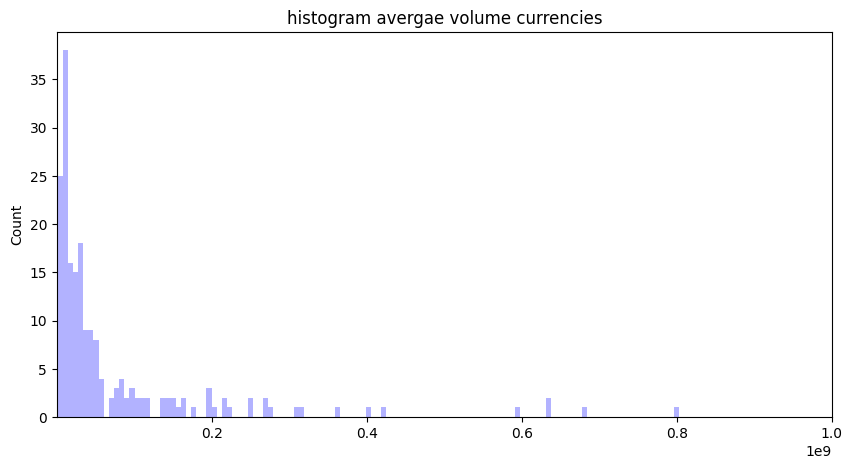

In [15]:
fig_1, ax_1 = plt.subplots(figsize=(10, 5))
sns.histplot(
    average_volume_cur, color="blue", alpha=0.3, edgecolor="w", ax=ax_1, bins=5000
)
plt.xlim(100000, 1000000000)
ax_1.set_title("histogram avergae volume currencies")

Text(0.5, 1.0, 'histogram mean average volume of samples of the currencies')

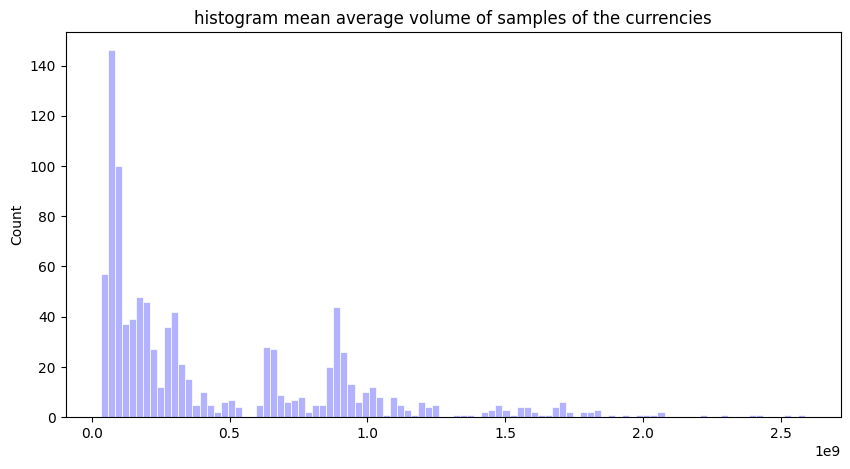

In [16]:
fig_1, ax_1 = plt.subplots(figsize=(10, 5))
sns.histplot(mean_sample_vol, color="blue", alpha=0.3, edgecolor="w", ax=ax_1, bins=100)
ax_1.set_title("histogram mean average volume of samples of the currencies")

As we can see, the histogram of the average volume 24h of currencies and the average volume 24h samples taken from curencies **does not have a distribution similar to the normal distribution**, so **we cannot use the z-score method** to find confidence interval.Therefore, we use the **bootstrap method**, which **does not require the normality of the data distribution**.

In bootstarp method, we take many samples from the population and keep the average of all samples. After that, we sort all these averages in ascending order, and among these averages, we select the two averages that 98% of the averages are in the interval between these two averages as the lower bound and the upper bound.

In [17]:
bootstrap_means = []
for _ in range(100):
    bootstrap_sample = np.random.choice(average_volume_cur, size=40, replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_means.append(bootstrap_mean)

alpha = 0.02
bootstrap_means.sort()
lower_bound_idx = int((alpha / 2) * 100)
upper_bound_idx = int((1 - alpha / 2) * 100) - 1
lower_bound = bootstrap_means[lower_bound_idx]
upper_bound = bootstrap_means[upper_bound_idx]
    

print("Confidence Interval: (",lower_bound, ',', upper_bound, ")")
print("lower_bound :", lower_bound)
print("actual_mean :", mean_avg_vol)
print("upper_bound :", upper_bound)

Confidence Interval: ( 43370599.979797386 , 1872847876.3255749 )
lower_bound : 43370599.979797386
actual_mean : 446728551.866224
upper_bound : 1872847876.3255749


<h3>Hypothesis test 1:</h3>

<h5>Reading data:</h5>


In [18]:
conn = engine.connect()

# Define the SQL query
sql_query = text(
    """
    select close - open as 'change' from historical
    where dayname(timestamp) in ('Sunday', 'Monday', 'Tuesday');
"""
)

# Method 2 using sql alchemy

# query = (
#     session.query(Historical.close - Historical.open)
#     .filter(func.strftime('%A', func.datetime.fromtimestamp(Historical.timestamp)) in formatted_days)
# )
# results = query.all()


# Execute the SQL query
result = conn.execute(sql_query)

# Fetch the results
selected_rows = result.fetchall()

# Close the database connection when you're done
conn.close()

df1 = pd.DataFrame(
    [(r.change) for r in selected_rows],
    columns=["change"]
)

conn = engine.connect()

# Define the SQL query
sql_query = text(
    """
    select close - open as 'change' from historical
    where dayname(timestamp) in ('Thursday', 'Friday', 'Saturday');
"""
)

# Method 2 using sql alchemy

# query = (
#     session.query(Historical.close - Historical.open)
#     .filter(func.strftime('%A', func.datetime.fromtimestamp(Historical.timestamp)) in days_to_filter)
#     .label('change')
# )

# results = query.all()

# Execute the SQL query
result = conn.execute(sql_query)

# Fetch the results
selected_rows = result.fetchall()

# Close the database connection when you're done
conn.close()

df2 = pd.DataFrame(
    [(r.change) for r in selected_rows],
    columns=["change"]
)

In [19]:
price_change_sunday = np.concatenate(np.array(df1))
price_change_thursday = np.concatenate(np.array(df2))

mean_sun = np.mean(price_change_sunday)
std_sun = np.std(price_change_sunday)
mean_thur = np.mean(price_change_thursday)
std_thur = np.std(price_change_thursday)

print("mean and std of price changes on sunday group   :", mean_sun, " - ", std_sun)
print("mean and std of price changes on thursday group :", mean_thur, " - ", std_thur)

mean and std of price changes on sunday group   : 0.4199304116238857  -  63.67490067588489
mean and std of price changes on thursday group : 0.1464000495617376  -  61.696591629364626


As we can see, the average of the two populations is almost equal, but their standard deviation is high,
 and we cannot draw a definite conclusion from this comparison. So we use the hypothesis test.

In [20]:
sample_sun = []
for i in range(1000):
    sample_sun.append(np.random.choice(price_change_sunday, size=1000, replace=True))
sample_sun = np.array(sample_sun)

sample_thur = []
for i in range(1000):
    sample_thur.append(np.random.choice(price_change_thursday, size=1000, replace=True))
sample_thur = np.array(sample_thur)

In [21]:
mean_sample_sun = []
for sample in sample_sun:
    mean_sample_sun.append(np.mean(sample))

mean_sample_thur = []
for sample in sample_thur:
    mean_sample_thur.append(np.mean(sample))

Text(0.5, 1.0, 'histogram mean price changes of samples of the thursday group')

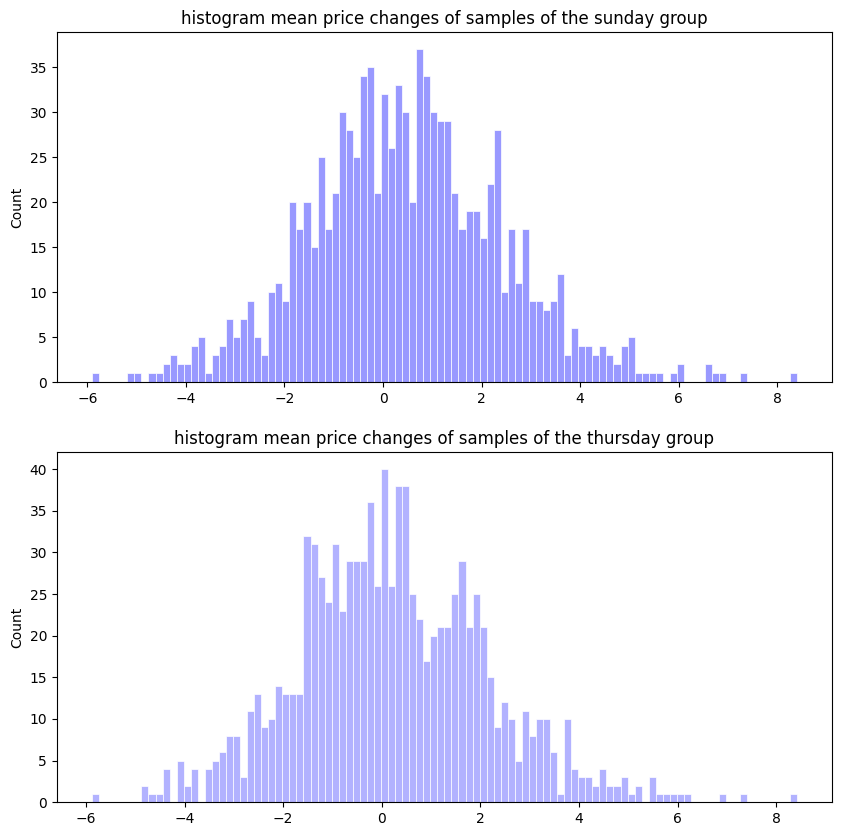

In [22]:
fig_1, ax_1 = plt.subplots(2, 1, figsize=(10, 10))
sns.histplot(
    mean_sample_sun, color="blue", alpha=0.4, edgecolor="w", ax=ax_1[0], bins=100
)
sns.histplot(
    mean_sample_thur, color="blue", alpha=0.3, edgecolor="w", ax=ax_1[1], bins=100
)
ax_1[0].set_title("histogram mean price changes of samples of the sunday group")
ax_1[1].set_title("histogram mean price changes of samples of the thursday group")

These two histogram show that the distribution of the average samples of the two populations is almost normal, so we can use the t-test **assuming that the samples observed in the population are independent from each other**. Also, since the currencies are the same in two populations, we use the **paired t-test**.

In [45]:
sample_pop1 = np.random.choice(price_change_sunday, size=5000, replace=True)
sample_pop2 = np.random.choice(price_change_thursday, size=5000, replace=True)

t_statistic, p_value = stats.ttest_rel(sample_pop1, sample_pop2)
print("P-value:", p_value)

P-value: 0.43121960671174875


The null hypothesis is that the **expected value of the mean of the two samples is equal**, and considering the value of P, we **cannot reject** this hypothesis.

To use the t test, we assumed that the **samples observed in the two populations are independent of each other**, but we know that in reality this assumption is not correct, for example:<br> <ul> <li>sharp increase or decrease in the price of currencies with a high market kap affects the entire market.</li> <li>if a currency has a sharp price change in one day, this price change will be effective in the coming days.</li> </ul>
so we use **Wilcoxon signed-rank** test that is non-parametric test and it dosen't require data independency.

In [46]:
t_statistic, p_value = stats.wilcoxon(sample_pop1, sample_pop2)
print("P-value:", p_value)

P-value: 0.45079243379139866


Same as t-test the null hypothesis is that the **expected value of the mean of the two samples is equal**, and considering the value of P, we **cannot reject** this hypothesis.

<h3>Conclusion:</h3>
Since there was no significant difference between the average price difference in the two groups, it does not matter which working days we choose.

<h3>Hypothesis test 2:</h3>

<h5>Reading data:</h5>


In [47]:
conn = engine.connect()

# Define the SQL query
sql_query = text(
    """
    select volume from historical 
    join currencies.currency c on c.id = historical.currency_id
    where c.name in ('Bitcoin', 'Ethereum', 'Tether USDt');
"""
)

# Method 2 using sql alchemy

# query = (
#     session.query(Historical.volume)
#     .join(Currency, Currency.id == Historical.currency_id)
#     .filter(Currency.name.in_(currency_names_to_filter))
# )
# results = query.all()


# Execute the SQL query
result = conn.execute(sql_query)

# Fetch the results
selected_rows = result.fetchall()

# Close the database connection when you're done
conn.close()

df1 = pd.DataFrame(
    [(r.volume) for r in selected_rows],
    columns=["volume"]
)

conn = engine.connect()

# Define the SQL query
sql_query = text(
    """
    select volume from historical
    join currencies.currency c on c.id = historical.currency_id
    where c.name not in ('Bitcoin', 'Ethereum', 'Tether USDt');
"""
)

# Method 2 using sql alchemy

# query = (
#     session.query(Historical.volume)
#     .join(Currency, Currency.id == Historical.currency_id)
#     .filter(~Currency.name.in_(currency_names_to_exclude))
# )

# results = query.all()

# Execute the SQL query
result = conn.execute(sql_query)

# Fetch the results
selected_rows = result.fetchall()

# Close the database connection when you're done
conn.close()

df2 = pd.DataFrame(
    [(r.volume) for r in selected_rows],
    columns=["volume"]
)

In [48]:
volume_top_cur = np.concatenate(np.array(df1))
volume_stable_cur = np.concatenate(np.array(df2))

mean_top = np.mean(volume_top_cur)
std_top = np.std(volume_top_cur)
mean_stable = np.mean(volume_stable_cur)
std_stable = np.std(volume_stable_cur)

print("mean and std of volume 24h top currencies    :", mean_top, "  - ", std_top)
print("mean and std of volume 24h stable currencies :", mean_stable, " - ", std_stable)

mean and std of volume 24h top currencies    : 21653600509.93253   -  16575049003.320984
mean and std of volume 24h stable currencies : 123104793.75706387  -  577794982.0529991


As we can see, the mean of the two populations has a large distance, but the standard deviation of the first population is also extremely high. And we cannot draw a definite conclusion from this comparison. Therefore, we use the hypothesis test.

In [49]:
sample_top = []
for i in range(1000):
    sample_top.append(np.random.choice(volume_top_cur, size=1000, replace=True))
sample_top = np.array(sample_top)

sample_stable = []
for i in range(1000):
    sample_stable.append(np.random.choice(volume_stable_cur, size=1000, replace=True))
sample_stable = np.array(sample_stable)

In [50]:
mean_sample_top = []
for sample in sample_top:
    mean_sample_top.append(np.mean(sample))

mean_sample_stable = []
for sample in sample_stable:
    mean_sample_stable.append(np.mean(sample))

Text(0.5, 1.0, 'histogram mean volume of samples of the stable curencies')

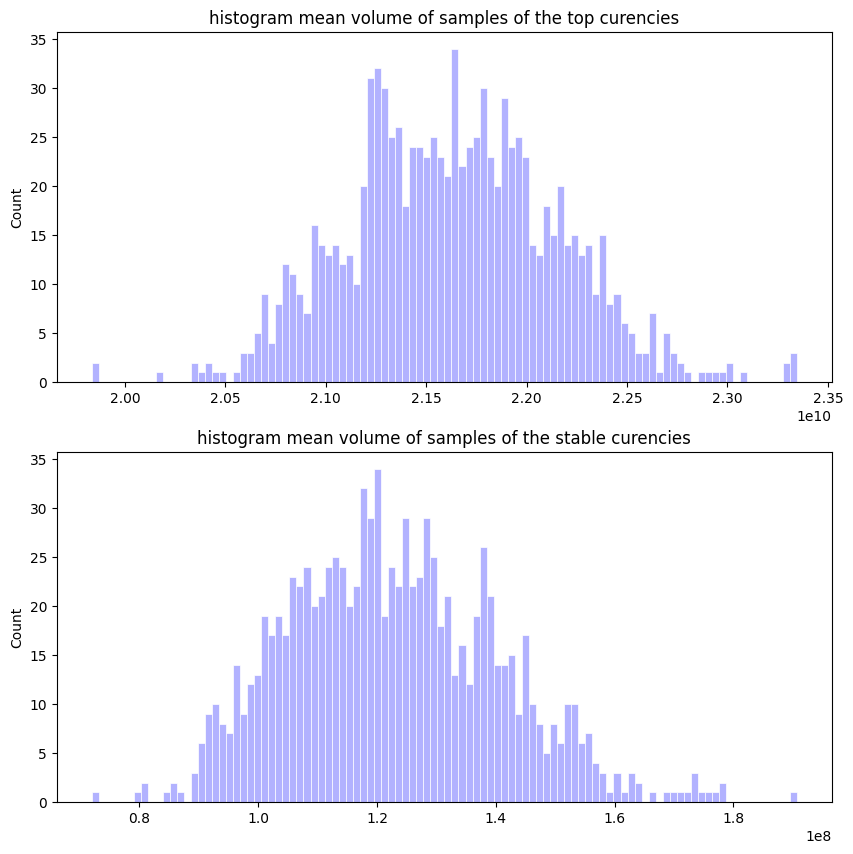

In [51]:
fig_1, ax_1 = plt.subplots(2, 1, figsize=(10, 10))
sns.histplot(
    mean_sample_top, color="blue", alpha=0.3, edgecolor="w", ax=ax_1[0], bins=100
)
sns.histplot(
    mean_sample_stable, color="blue", alpha=0.3, edgecolor="w", ax=ax_1[1], bins=100
)
ax_1[0].set_title("histogram mean volume of samples of the top curencies")
ax_1[1].set_title("histogram mean volume of samples of the stable curencies")

These two histogram show that the distribution of the average samples of the two populations is almost normal, so we can use the t-test, **but the variance of the two populations is far from each other**, so we must use the **Welch t-test**, which does not require the variance of the two populations to be equal.

In [52]:
t_statistic, p_value = stats.ttest_ind(sample_top[0], sample_stable[0], equal_var=False)
print("P-value:", p_value)

P-value: 1.3406892290643562e-227


The null hypothesis in this test was that **the expected value of the average of the two populations is the same**, but according to the P value, we **can reject** this assumption.

<h3>Conclusion:</h3>
Since the average of the two populations had a significant difference, the average daily volume of Bitcoin, Ethereum and Tether USDt is much higher than the average daily volume of other cryptocurrencies.

<h3>Hypothesis test 3:</h3>

<h5>Reading data:</h5>


In [ ]:
conn = engine.connect()

# Define the SQL query
sql_query = text(
    """
    select close - open as 'change' from historical
    where dayname(timestamp) in ('Sunday', 'Saturday');
"""
)

# Method 2 using sql alchemy

# query = (
#     session.query(Historical.close - Historical.open)
#     .filter(func.strftime('%A', func.datetime.fromtimestamp(Historical.timestamp)) in days_to_filter)
#     .label('change')
# )

# results = query.all()

# Execute the SQL query
result = conn.execute(sql_query)

# Fetch the results
selected_rows = result.fetchall()

# Close the database connection when you're done
conn.close()

df1 = pd.DataFrame(
    [(r.change) for r in selected_rows],
    columns=["change"]
)

In [11]:
price_change_weekend = np.concatenate(np.array(df1))

mean_weekend = np.mean(price_change_weekend)
std_weekend = np.std(price_change_weekend)
print(
    "mean and std of price changes on the weekend :", mean_weekend, " - ", std_weekend
)

mean and std of price changes on the weekend : 0.16971375140217426  -  41.38663276656512


The mean and standard deviation do not give us information about the distribution of the data :)

Text(0.5, 1.0, 'histogram price changes on the weekend')

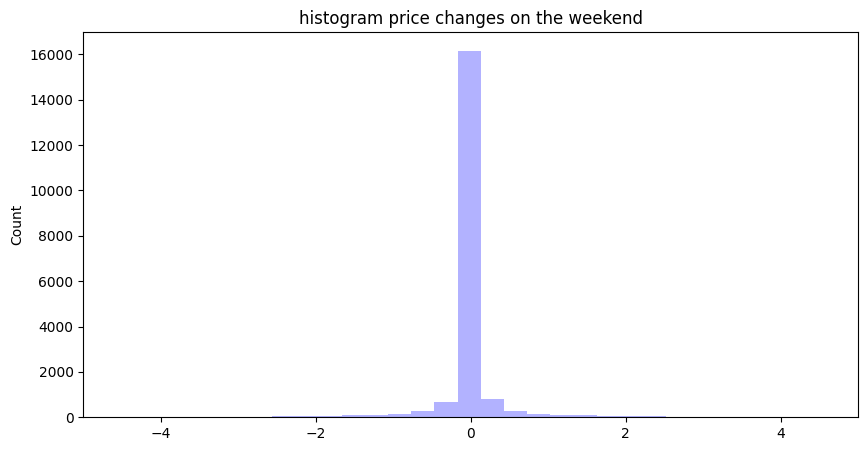

In [12]:
fig_1, ax_1 = plt.subplots(figsize=(10, 5))
sns.histplot(
    price_change_weekend, color="blue", alpha=0.3, edgecolor="w", ax=ax_1, bins=10000
)
plt.xlim(-5, 5)
ax_1.set_title("histogram price changes on the weekend")

The histogram of the data has a shape similar to the normal distribution, but it's **peak is very high**, and we need to use hypothesis test to know the data distribution is normal or not.

In [20]:
sample_weekend = np.random.choice(price_change_weekend, size=5000, replace=True)
statistic, p_value = stats.shapiro(sample_weekend)
print("P-value Shapiro-Wilk test :", p_value)

statistic, p_value = stats.jarque_bera(sample_weekend)
print("P-value Jarque-Bera test  :", p_value)

P-value Shapiro-Wilk test : 0.0
P-value Jarque-Bera test  : 0.0


The null hypothesis of both these tests is that **the population has a normal distribution**, but since the p-value is **zero**, the **population does not have a normal distribution**.<br>
The difference between these two tests is that **Jarque-Bera** test focuses on **skewness and kurtosis**, while **Shapiro-Wilk** test focuses on the **correlation between the observed data and the expected values from a normal distribution**, also **Jarque_Bera** test dose not have any limitation on the sample size but maximum size of sample for **Shapiro-Wilk** test is 5000.

<h3>Hypothesis test 4(Additional):</h3>

**Hossein Ebrahimian** claims that the percentage of using newer and older programming languages in cryptocurrency projects is the same. Now, since he doesn't know anything about statistics, we have to prove his claim. For this purpose, we used 4 programming languages that were released in the **21st** century **(Go 2009, Rast 2015, TypeScript 2012, and Solidity 2014)** and 4 programming languages that were released in the **20th** century **(C 1972, CPP 1985, Java Script 1995, and Python 1991)**.we check the average percentage of use of these 2 groups of programming languages in projects (each of these languages have been used in at least 20 projects.)

<h5>Reading data:</h5>


In [ ]:
conn = engine.connect()

# Define the SQL query
sql_query = text(
    """
    select percentage from languages_currency 
    join currencies.languages c on c.id = languages_currency.language_id
    where c.name in ('Go', 'Rust', 'TypeScript', 'Solidity');
"""
)

# Method 2 using sql alchemy


# query = (
#     session.query(LanguagesCurrency.percentage)
#     .join(Languages, Languages.id == LanguagesCurrency.language_id)
#     .filter(Languages.name.in_(language_names_to_include))
# )

# results = query.all()

# Execute the SQL query
result = conn.execute(sql_query)

# Fetch the results
selected_rows = result.fetchall()

# Close the database connection when you're done
conn.close()

df1 = pd.DataFrame(
    [(r.percentage) for r in selected_rows],
    columns=["percentage"]
)

conn = engine.connect()

# Define the SQL query
sql_query = text(
    """
    select percentage from languages_currency
    join currencies.languages c on c.id = languages_currency.language_id
    where c.name in ('C++', 'JavaScript', 'C', 'Python');
"""
)


# Method 2 using sql alchemy

# query = (
#     session.query(LanguagesCurrency.percentage)
#     .join(Languages, Languages.id == LanguagesCurrency.language_id)
#     .filter(Languages.name.in_(language_names_to_include))
# )

# results = query.all()

# Execute the SQL query
result = conn.execute(sql_query)

# Fetch the results
selected_rows = result.fetchall()

# Close the database connection when you're done
conn.close()

df2 = pd.DataFrame(
    [(r.percentage) for r in selected_rows],
    columns=["percentage"]
)

In [65]:
new_lang_percent = np.concatenate(np.array(df1))
old_lang_percent = np.concatenate(np.array(df2))

mean_new = np.mean(new_lang_percent)
std_new = np.std(new_lang_percent)
mean_old = np.mean(old_lang_percent)
std_old = np.std(old_lang_percent)

print(
    "mean and std of usage percentage of new top programming languages :",
    mean_new," - ",std_new,
)
print(
    "mean and std of usage percentage of old top programming languages :",
    mean_old," - ",std_old,
)

mean and std of usage percentage of new top programming languages : 48.48081395348838  -  37.53937984133946
mean and std of usage percentage of old top programming languages : 24.77956989247312  -  29.41003069007837


As we can see, the mean of new langages is greather than old languages, but the standard deviation of the two grops is high.So we cannot draw a definite conclusion from this comparison. Therefore, we use the hypothesis test.

Text(0.5, 1.0, 'histogram usage percentage of old top programing languages')

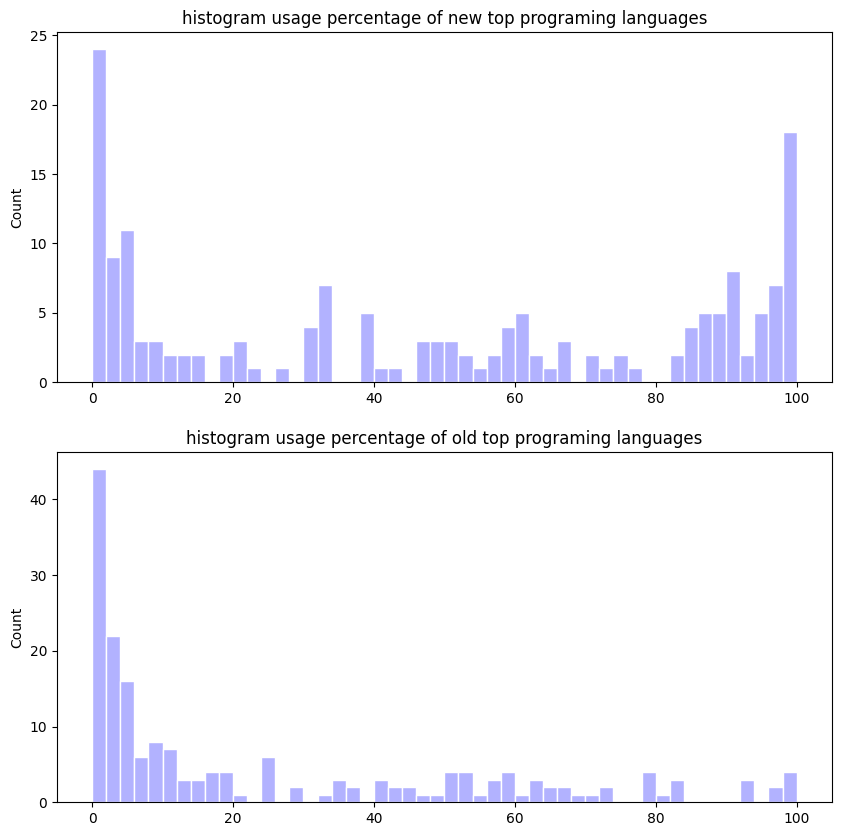

In [66]:
fig_1, ax_1 = plt.subplots(2, 1, figsize=(10, 10))
sns.histplot(new_lang_percent, color="blue", alpha=0.3, edgecolor="w", ax=ax_1[0], bins=50)
ax_1[0].set_title("histogram usage percentage of new top programing languages")
sns.histplot(old_lang_percent, color="blue", alpha=0.3, edgecolor="w", ax=ax_1[1], bins=50)
ax_1[1].set_title("histogram usage percentage of old top programing languages")

Histograms show that the distribution of both groups is **not normal**

In [70]:
sample_new = []
for i in range(1000):
    sample_new.append(np.random.choice(new_lang_percent, size=50, replace=True))
sample_new = np.array(sample_new)

sample_old = []
for i in range(1000):
    sample_old.append(np.random.choice(old_lang_percent, size=50, replace=True))
sample_old = np.array(sample_old)

mean_sample_new = []
for sample in sample_new:
    mean_sample_new.append(np.mean(sample))

mean_sample_old = []
for sample in sample_old:
    mean_sample_old.append(np.mean(sample))

Text(0.5, 1.0, 'histogram mean usage percent of samples of the new top languages')

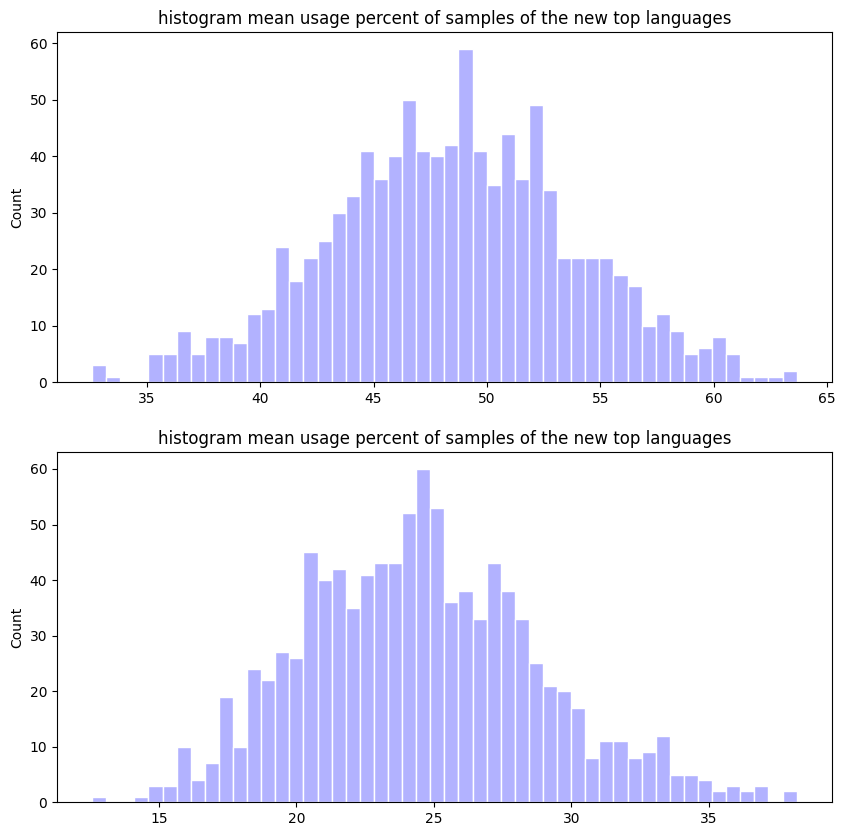

In [71]:
fig_1, ax_1 = plt.subplots(2, 1, figsize=(10, 10))
sns.histplot(mean_sample_new, color="blue", alpha=0.3, edgecolor="w", ax=ax_1[0], bins=50)
ax_1[0].set_title("histogram mean usage percent of samples of the new top languages")

sns.histplot(mean_sample_old, color="blue", alpha=0.3, edgecolor="w", ax=ax_1[1], bins=50)
ax_1[1].set_title("histogram mean usage percent of samples of the new top languages")

These two histogram show that the distribution of the average samples of the two populations is almost normal, so we can use the t-test, **but the variance of the two populations is not equal**, so we must use the **Welch t-test**, which does not require the variance of the two populations to be equal.

In [72]:
t_statistic, p_value = stats.ttest_ind(sample_new[0], sample_old[0], equal_var=False)
print("P-value:", p_value)

P-value: 2.4413785563638207e-06


The null hypothesis in this test was that **the expected value of the average of the two populations is the same**, but according to the P value, we **can reject** this assumption.Therefore, Hossein's claim was wrong and the average percentage of using new programming languages in cryptocurrency projects is higher.